In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import xlnet
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import model_utils
import pickle
import json
pad_sequences = tf.keras.preprocessing.sequence.pad_sequences

In [3]:
import sentencepiece as spm
from prepro_utils import preprocess_text, encode_ids

sp_model = spm.SentencePieceProcessor()
sp_model.Load('sp10m.cased.v9.model')

def tokenize_fn(text):
    text = preprocess_text(text, lower= False)
    return encode_ids(sp_model, text)

In [4]:
SEG_ID_A   = 0
SEG_ID_B   = 1
SEG_ID_CLS = 2
SEG_ID_SEP = 3
SEG_ID_PAD = 4

special_symbols = {
    "<unk>"  : 0,
    "<s>"    : 1,
    "</s>"   : 2,
    "<cls>"  : 3,
    "<sep>"  : 4,
    "<pad>"  : 5,
    "<mask>" : 6,
    "<eod>"  : 7,
    "<eop>"  : 8,
}

VOCAB_SIZE = 32000
UNK_ID = special_symbols["<unk>"]
CLS_ID = special_symbols["<cls>"]
SEP_ID = special_symbols["<sep>"]
MASK_ID = special_symbols["<mask>"]
EOD_ID = special_symbols["<eod>"]

In [5]:
import pickle

with open('/home/husein/xlnet/train_X.pkl', 'rb') as fopen:
    train_X, train_Y, train_depends, train_segments, train_masks = pickle.load(fopen)
    
with open('/home/husein/xlnet/test_X.pkl', 'rb') as fopen:
    test_X, test_Y, test_depends, test_segments, test_masks = pickle.load(fopen)
    
with open('/home/husein/xlnet/tags.pkl', 'rb') as fopen:
    idx2tag, tag2idx = pickle.load(fopen)

In [6]:
kwargs = dict(
      is_training=True,
      use_tpu=False,
      use_bfloat16=False,
      dropout=0.1,
      dropatt=0.1,
      init='normal',
      init_range=0.1,
      init_std=0.05,
      clamp_len=-1)

xlnet_parameters = xlnet.RunConfig(**kwargs)
xlnet_config = xlnet.XLNetConfig(
    json_path = 'alxlnet-base-2020-04-10/config.json'
)

In [7]:
epoch = 3
batch_size = 8
warmup_proportion = 0.1
num_train_steps = int(len(train_X) / batch_size * epoch)
num_warmup_steps = int(num_train_steps * warmup_proportion)
print(num_train_steps, num_warmup_steps)

training_parameters = dict(
      decay_method = 'poly',
      train_steps = num_train_steps,
      learning_rate = 2e-5,
      warmup_steps = num_warmup_steps,
      min_lr_ratio = 0.0,
      weight_decay = 0.00,
      adam_epsilon = 1e-8,
      num_core_per_host = 1,
      lr_layer_decay_rate = 1,
      use_tpu=False,
      use_bfloat16=False,
      dropout=0.0,
      dropatt=0.0,
      init='normal',
      init_range=0.1,
      init_std=0.02,
      clip = 1.0,
      clamp_len=-1,)

1173456 117345


In [8]:
class Parameter:
    def __init__(self, decay_method, warmup_steps, weight_decay, adam_epsilon, 
                num_core_per_host, lr_layer_decay_rate, use_tpu, learning_rate, train_steps,
                min_lr_ratio, clip, **kwargs):
        self.decay_method = decay_method
        self.warmup_steps = warmup_steps
        self.weight_decay = weight_decay
        self.adam_epsilon = adam_epsilon
        self.num_core_per_host = num_core_per_host
        self.lr_layer_decay_rate = lr_layer_decay_rate
        self.use_tpu = use_tpu
        self.learning_rate = learning_rate
        self.train_steps = train_steps
        self.min_lr_ratio = min_lr_ratio
        self.clip = clip
        
training_parameters = Parameter(**training_parameters)

In [9]:
class BiAAttention:
    def __init__(self, input_size_encoder, input_size_decoder, num_labels):
        self.input_size_encoder = input_size_encoder
        self.input_size_decoder = input_size_decoder
        self.num_labels = num_labels
        
        self.W_d = tf.get_variable("W_d", shape=[self.num_labels, self.input_size_decoder],
           initializer=tf.contrib.layers.xavier_initializer())
        self.W_e = tf.get_variable("W_e", shape=[self.num_labels, self.input_size_encoder],
           initializer=tf.contrib.layers.xavier_initializer())
        self.U = tf.get_variable("U", shape=[self.num_labels, self.input_size_decoder, self.input_size_encoder],
           initializer=tf.contrib.layers.xavier_initializer())
        
    def forward(self, input_d, input_e, mask_d=None, mask_e=None):
        batch = tf.shape(input_d)[0]
        length_decoder = tf.shape(input_d)[1]
        length_encoder = tf.shape(input_e)[1]
        out_d = tf.expand_dims(tf.matmul(self.W_d, tf.transpose(input_d, [0, 2, 1])), 3)
        out_e = tf.expand_dims(tf.matmul(self.W_e, tf.transpose(input_e, [0, 2, 1])), 2)
        output = tf.matmul(tf.expand_dims(input_d, 1), self.U)
        output = tf.matmul(output, tf.transpose(tf.expand_dims(input_e, 1), [0, 1, 3, 2]))
        
        output = output + out_d + out_e
        
        if mask_d is not None:
            d = tf.expand_dims(tf.expand_dims(mask_d, 1), 3)
            e = tf.expand_dims(tf.expand_dims(mask_e, 1), 2)
            output = output * d * e
            
        return output
    
class BiLinear:
    def __init__(self, left_features, right_features, out_features):
        self.left_features = left_features
        self.right_features = right_features
        self.out_features = out_features
        
        self.U = tf.get_variable("U-bi", shape=[out_features, left_features, right_features],
           initializer=tf.contrib.layers.xavier_initializer())
        self.W_l = tf.get_variable("Wl", shape=[out_features, left_features],
           initializer=tf.contrib.layers.xavier_initializer())
        self.W_r = tf.get_variable("Wr", shape=[out_features, right_features],
           initializer=tf.contrib.layers.xavier_initializer())
    
    def forward(self, input_left, input_right):
        left_size = tf.shape(input_left)
        output_shape = tf.concat([left_size[:-1], [self.out_features]], axis = 0)
        batch = tf.cast(tf.reduce_prod(left_size[:-1]), tf.int32)
        input_left = tf.reshape(input_left, (batch, self.left_features))
        input_right = tf.reshape(input_right, (batch, self.right_features))
        tiled = tf.tile(tf.expand_dims(input_left, axis = 0), (self.out_features,1,1))
        output = tf.transpose(tf.reduce_sum(tf.matmul(tiled, self.U), axis = 2))
        output = output + tf.matmul(input_left, tf.transpose(self.W_l))\
        + tf.matmul(input_right, tf.transpose(self.W_r))
        
        return tf.reshape(output, output_shape)


    
    def decode(self, input_word, input_char, mask, leading_symbolic=0):
        out_arc, out_type, _ = self.forward(input_word, input_char, mask)
        batch = tf.shape(out_arc)[0]
        max_len = tf.shape(out_arc)[1]
        sec_max_len = tf.shape(out_arc)[2]
        out_arc = out_arc + tf.linalg.diag(tf.fill([max_len], -np.inf))
        minus_mask = tf.expand_dims(tf.cast(1 - mask, tf.bool), axis = 2)
        minus_mask = tf.tile(minus_mask, [1, 1, sec_max_len])
        out_arc = tf.where(minus_mask, tf.fill(tf.shape(out_arc), -np.inf), out_arc)
        heads = tf.argmax(out_arc, axis = 1)
        type_h, type_c = out_type
        batch = tf.shape(type_h)[0]
        max_len = tf.shape(type_h)[1]
        batch_index = tf.range(0, batch)
        t = tf.cast(tf.transpose(heads), tf.int32)
        broadcasted = tf.broadcast_to(batch_index, tf.shape(t))
        concatenated = tf.transpose(tf.concat([tf.expand_dims(broadcasted, axis = 0), 
                                               tf.expand_dims(t, axis = 0)], axis = 0))
        type_h = tf.gather_nd(type_h, concatenated)
        out_type = self.bilinear.forward(type_h, type_c)
        out_type = out_type[:, :, leading_symbolic:]
        types = tf.argmax(out_type, axis = 2)
        return heads, types
    
class Model:
    def __init__(
        self,
        learning_rate,
        hidden_size_word,
        cov = 0.0):
        
        self.words = tf.placeholder(tf.int32, (None, None))
        self.segment_ids = tf.placeholder(tf.int32, [None, None])
        self.input_masks = tf.placeholder(tf.float32, [None, None])
        self.heads = tf.placeholder(tf.int32, (None, None))
        self.types = tf.placeholder(tf.int32, (None, None))
        self.switch = tf.placeholder(tf.bool, None)
        self.mask = tf.cast(tf.math.not_equal(self.words, 0), tf.float32)
        self.maxlen = tf.shape(self.words)[1]
        self.lengths = tf.count_nonzero(self.words, 1)
        mask = self.mask
        heads = self.heads
        types = self.types
        
        self.arc_h = tf.layers.Dense(hidden_size_word)
        self.arc_c = tf.layers.Dense(hidden_size_word)
        self.attention = BiAAttention(hidden_size_word, hidden_size_word, 1)

        self.type_h = tf.layers.Dense(hidden_size_word)
        self.type_c = tf.layers.Dense(hidden_size_word)
        self.bilinear = BiLinear(hidden_size_word, hidden_size_word, len(tag2idx))
        
        xlnet_model = xlnet.XLNetModel(
            xlnet_config=xlnet_config,
            run_config=xlnet_parameters,
            input_ids=tf.transpose(self.words, [1, 0]),
            seg_ids=tf.transpose(self.segment_ids, [1, 0]),
            input_mask=tf.transpose(self.input_masks, [1, 0]))
        output_layer = xlnet_model.get_sequence_output()
        output_layer = tf.transpose(output_layer, [1, 0, 2])
        
        arc_h = tf.nn.elu(self.arc_h(output_layer))
        arc_c = tf.nn.elu(self.arc_c(output_layer))
        
        type_h = tf.nn.elu(self.type_h(output_layer))
        type_c = tf.nn.elu(self.type_c(output_layer))
        
        out_arc = tf.squeeze(self.attention.forward(arc_h, arc_c, mask_d=self.mask, 
                                                    mask_e=self.mask), axis = 1)
        
        batch = tf.shape(out_arc)[0]
        max_len = tf.shape(out_arc)[1]
        sec_max_len = tf.shape(out_arc)[2]
        batch_index = tf.range(0, batch)
        
        decode_arc = out_arc + tf.linalg.diag(tf.fill([max_len], -np.inf))
        minus_mask = tf.expand_dims(tf.cast(1 - mask, tf.bool), axis = 2)
        minus_mask = tf.tile(minus_mask, [1, 1, sec_max_len])
        decode_arc = tf.where(minus_mask, tf.fill(tf.shape(decode_arc), -np.inf), decode_arc)
        self.heads_seq = tf.argmax(decode_arc, axis = 1)
        self.heads_seq = tf.identity(self.heads_seq, name = 'heads_seq')
        
        t = tf.cast(tf.transpose(self.heads_seq), tf.int32)
        broadcasted = tf.broadcast_to(batch_index, tf.shape(t))
        concatenated = tf.transpose(tf.concat([tf.expand_dims(broadcasted, axis = 0), 
                                               tf.expand_dims(t, axis = 0)], axis = 0))
        type_h = tf.gather_nd(type_h, concatenated)
        out_type = self.bilinear.forward(type_h, type_c)
        self.tags_seq = tf.argmax(out_type, axis = 2)
        self.tags_seq = tf.identity(self.tags_seq, name = 'tags_seq')
        
        log_likelihood, transition_params = tf.contrib.crf.crf_log_likelihood(
            out_type, self.types, self.lengths
        )
        crf_loss = tf.reduce_mean(-log_likelihood)
        self.logits, _ = tf.contrib.crf.crf_decode(
            out_type, transition_params, self.lengths
        )
        self.logits = tf.identity(self.logits, name = 'logits')
        
        batch = tf.shape(out_arc)[0]
        max_len = tf.shape(out_arc)[1]
        batch_index = tf.range(0, batch)
        t = tf.transpose(heads)
        broadcasted = tf.broadcast_to(batch_index, tf.shape(t))
        concatenated = tf.transpose(tf.concat([tf.expand_dims(broadcasted, axis = 0), 
                                               tf.expand_dims(t, axis = 0)], axis = 0))
        type_h = tf.gather_nd(type_h, concatenated)
        out_type = self.bilinear.forward(type_h, type_c)
        minus_inf = -1e8
        minus_mask = (1 - mask) * minus_inf
        out_arc = out_arc + tf.expand_dims(minus_mask, axis = 2) + tf.expand_dims(minus_mask, axis = 1)
        loss_arc = tf.nn.log_softmax(out_arc, dim=1)
        loss_type = tf.nn.log_softmax(out_type, dim=2)
        loss_arc = loss_arc * tf.expand_dims(mask, axis = 2) * tf.expand_dims(mask, axis = 1)
        loss_type = loss_type * tf.expand_dims(mask, axis = 2)
        num = tf.reduce_sum(mask) - tf.cast(batch, tf.float32)
        child_index = tf.tile(tf.expand_dims(tf.range(0, max_len), 1), [1, batch])
        t = tf.transpose(heads)
        broadcasted = tf.broadcast_to(batch_index, tf.shape(t))
        concatenated = tf.transpose(tf.concat([tf.expand_dims(broadcasted, axis = 0),
                                               tf.expand_dims(t, axis = 0),
                                               tf.expand_dims(child_index, axis = 0)], axis = 0))
        loss_arc = tf.gather_nd(loss_arc, concatenated)
        loss_arc = tf.transpose(loss_arc, [1, 0])
        
        t = tf.transpose(types)
        broadcasted = tf.broadcast_to(batch_index, tf.shape(t))
        concatenated = tf.transpose(tf.concat([tf.expand_dims(broadcasted, axis = 0),
                                               tf.expand_dims(child_index, axis = 0),
                                               tf.expand_dims(t, axis = 0)], axis = 0))
        loss_type = tf.gather_nd(loss_type, concatenated)
        loss_type = tf.transpose(loss_type, [1, 0])
        cost = (tf.reduce_sum(-loss_arc) / num) + (tf.reduce_sum(-loss_type) / num)
        
        self.cost = tf.cond(self.switch, lambda: cost + crf_loss, lambda: cost)
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate = learning_rate
        ).minimize(self.cost)
        
        mask = tf.sequence_mask(self.lengths, maxlen = self.maxlen)
        
        self.prediction = tf.boolean_mask(self.logits, mask)
        mask_label = tf.boolean_mask(self.types, mask)
        correct_pred = tf.equal(tf.cast(self.prediction, tf.int32), mask_label)
        correct_index = tf.cast(correct_pred, tf.float32)
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        
        self.prediction = tf.cast(tf.boolean_mask(self.heads_seq, mask), tf.int32)
        mask_label = tf.boolean_mask(self.heads, mask)
        correct_pred = tf.equal(self.prediction, mask_label)
        correct_index = tf.cast(correct_pred, tf.float32)
        self.accuracy_depends = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [10]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

learning_rate = 2e-5
hidden_size_word = 256

model = Model(learning_rate, hidden_size_word)
sess.run(tf.global_variables_initializer())

Instructions for updating:
reduction_indices is deprecated, use axis instead
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




INFO:tensorflow:memory input None
INFO:tensorflow:Use float type <dtype: 'float32'>
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
dim is deprecated, use axis instead


In [11]:
import collections
import re

def get_assignment_map_from_checkpoint(tvars, init_checkpoint):
    """Compute the union of the current variables and checkpoint variables."""
    assignment_map = {}
    initialized_variable_names = {}

    name_to_variable = collections.OrderedDict()
    for var in tvars:
        name = var.name
        m = re.match('^(.*):\\d+$', name)
        if m is not None:
            name = m.group(1)
        name_to_variable[name] = var

    init_vars = tf.train.list_variables(init_checkpoint)

    assignment_map = collections.OrderedDict()
    for x in init_vars:
        (name, var) = (x[0], x[1])
        if name not in name_to_variable:
            continue
        assignment_map[name] = name_to_variable[name]
        initialized_variable_names[name] = 1
        initialized_variable_names[name + ':0'] = 1

    return (assignment_map, initialized_variable_names)

In [12]:
tvars = tf.trainable_variables()
checkpoint = 'alxlnet-base-2020-04-10/model.ckpt-300000'
assignment_map, initialized_variable_names = get_assignment_map_from_checkpoint(tvars, 
                                                                                checkpoint)

In [13]:
saver = tf.train.Saver(var_list = assignment_map)
saver.restore(sess, checkpoint)

INFO:tensorflow:Restoring parameters from alxlnet-base-2020-04-10/model.ckpt-300000


In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

batch_x = train_X[:5]
batch_x = pad_sequences(batch_x,padding='post')
batch_y = train_Y[:5]
batch_y = pad_sequences(batch_y,padding='post')
batch_depends = train_depends[:5]
batch_depends = pad_sequences(batch_depends,padding='post')
batch_segments = train_segments[:5]
batch_segments = pad_sequences(batch_segments, padding='post', value = 4)
batch_masks = train_masks[:5]
batch_masks = pad_sequences(batch_masks, padding='post', value = 1)

In [15]:
sess.run([model.accuracy, model.accuracy_depends, model.cost],
        feed_dict = {model.words: batch_x,
                model.types: batch_y,
                model.heads: batch_depends,
                model.segment_ids: batch_segments,
                model.input_masks: batch_masks,
                model.switch: False})

[0.08235294, 0.105882354, 40.901375]

In [16]:
sess.run([model.accuracy, model.accuracy_depends, model.cost],
        feed_dict = {model.words: batch_x,
                model.types: batch_y,
                model.heads: batch_depends,
                model.segment_ids: batch_segments,
                model.input_masks: batch_masks,
                model.switch: True})

[0.03529412, 0.07058824, 185.67154]

In [17]:
from tqdm import tqdm

epoch = 2
for e in range(epoch):
    train_acc, train_loss = [], []
    test_acc, test_loss = [], []
    train_acc_depends, test_acc_depends = [], []
    
    pbar = tqdm(
        range(0, len(train_X), batch_size), desc = 'train minibatch loop'
    )
    for i in pbar:
        index = min(i + batch_size, len(train_X))
        batch_x = train_X[i: index]
        batch_x = pad_sequences(batch_x,padding='post')
        batch_y = train_Y[i: index]
        batch_y = pad_sequences(batch_y,padding='post')
        batch_depends = train_depends[i: index]
        batch_depends = pad_sequences(batch_depends,padding='post')
        batch_segments = train_segments[i: index]
        batch_segments = pad_sequences(batch_segments, padding='post', value = 4)
        batch_masks = train_masks[i: index]
        batch_masks = pad_sequences(batch_masks, padding='post', value = 1)
        
        if batch_x.shape == batch_y.shape:
        
            acc_depends, acc, cost, _ = sess.run(
                [model.accuracy_depends, model.accuracy, model.cost, model.optimizer],
                feed_dict = {
                    model.words: batch_x,
                    model.types: batch_y,
                    model.heads: batch_depends,
                    model.segment_ids: batch_segments,
                    model.input_masks: batch_masks,
                    model.switch: False
                },
            )
            train_loss.append(cost)
            train_acc.append(acc)
            train_acc_depends.append(acc_depends)
            pbar.set_postfix(cost = cost, accuracy = acc, accuracy_depends = acc_depends)
        
    pbar = tqdm(
        range(0, len(test_X), batch_size), desc = 'test minibatch loop'
    )
    for i in pbar:
        index = min(i + batch_size, len(test_X))
        batch_x = test_X[i: index]
        batch_x = pad_sequences(batch_x,padding='post')
        batch_y = test_Y[i: index]
        batch_y = pad_sequences(batch_y,padding='post')
        batch_depends = test_depends[i: index]
        batch_depends = pad_sequences(batch_depends,padding='post')
        batch_segments = test_segments[i: index]
        batch_segments = pad_sequences(batch_segments, padding='post', value = 4)
        batch_masks = test_masks[i: index]
        batch_masks = pad_sequences(batch_masks, padding='post', value = 1)
        
        if batch_x.shape == batch_y.shape:
        
            acc_depends, acc, cost = sess.run(
                [model.accuracy_depends, model.accuracy, model.cost],
                feed_dict = {
                    model.words: batch_x,
                    model.types: batch_y,
                    model.heads: batch_depends,
                    model.segment_ids: batch_segments,
                    model.input_masks: batch_masks,
                    model.switch: False
                },
            )
            test_loss.append(cost)
            test_acc.append(acc)
            test_acc_depends.append(acc_depends)
            pbar.set_postfix(cost = cost, accuracy = acc, accuracy_depends = acc_depends)
    
    
    print(
    'epoch: %d, training loss: %f, training acc: %f, training depends: %f, valid loss: %f, valid acc: %f, valid depends: %f\n'
    % (e, np.mean(train_loss), 
       np.mean(train_acc), 
       np.mean(train_acc_depends), 
       np.mean(test_loss), 
       np.mean(test_acc), 
       np.mean(test_acc_depends)
    ))
    
    saver = tf.train.Saver(tf.trainable_variables())
    saver.save(sess, 'alxlnet-base-dependency/model.ckpt')

test minibatch loop: 100%|██████████| 1250/1250 [02:10<00:00,  9.56it/s, accuracy=0.871, accuracy_depends=0.834, cost=0.396] 


epoch: 0, training loss: 0.607109, training acc: 0.893016, training depends: 0.811151, valid loss: 0.446882, valid acc: 0.895227, valid depends: 0.837708



train minibatch loop:  15%|█▌        | 59495/391153 [2:52:23<16:05:17,  5.73it/s, accuracy=0.918, accuracy_depends=0.826, cost=0.41]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

train minibatch loop:  16%|█▌        | 62533/391153 [3:01:16<17:05:51,  5.34it/s, accuracy=0.89, accuracy_depends=0.884, cost=0.321]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

train minibatch loop:  16%|█▋        | 64313/391153 [3:06:25<15:51:45,  5.72it/s,

epoch: 1, training loss: 0.429685, training acc: 0.896941, training depends: 0.841408, valid loss: 0.403095, valid acc: 0.901645, valid depends: 0.845275



In [18]:
from tqdm import tqdm

epoch = 1
for e in range(epoch):
    train_acc, train_loss = [], []
    test_acc, test_loss = [], []
    train_acc_depends, test_acc_depends = [], []
    
    pbar = tqdm(
        range(0, len(train_X), batch_size), desc = 'train minibatch loop'
    )
    for i in pbar:
        index = min(i + batch_size, len(train_X))
        batch_x = train_X[i: index]
        batch_x = pad_sequences(batch_x,padding='post')
        batch_y = train_Y[i: index]
        batch_y = pad_sequences(batch_y,padding='post')
        batch_depends = train_depends[i: index]
        batch_depends = pad_sequences(batch_depends,padding='post')
        batch_segments = train_segments[i: index]
        batch_segments = pad_sequences(batch_segments, padding='post', value = 4)
        batch_masks = train_masks[i: index]
        batch_masks = pad_sequences(batch_masks, padding='post', value = 1)
        
        if batch_x.shape == batch_y.shape:
        
            acc_depends, acc, cost, _ = sess.run(
                [model.accuracy_depends, model.accuracy, model.cost, model.optimizer],
                feed_dict = {
                    model.words: batch_x,
                    model.types: batch_y,
                    model.heads: batch_depends,
                    model.segment_ids: batch_segments,
                    model.input_masks: batch_masks,
                    model.switch: True
                },
            )
            train_loss.append(cost)
            train_acc.append(acc)
            train_acc_depends.append(acc_depends)
            pbar.set_postfix(cost = cost, accuracy = acc, accuracy_depends = acc_depends)
        
    pbar = tqdm(
        range(0, len(test_X), batch_size), desc = 'test minibatch loop'
    )
    for i in pbar:
        index = min(i + batch_size, len(test_X))
        batch_x = test_X[i: index]
        batch_x = pad_sequences(batch_x,padding='post')
        batch_y = test_Y[i: index]
        batch_y = pad_sequences(batch_y,padding='post')
        batch_depends = test_depends[i: index]
        batch_depends = pad_sequences(batch_depends,padding='post')
        batch_segments = test_segments[i: index]
        batch_segments = pad_sequences(batch_segments, padding='post', value = 4)
        batch_masks = test_masks[i: index]
        batch_masks = pad_sequences(batch_masks, padding='post', value = 1)
        
        if batch_x.shape == batch_y.shape:
        
            acc_depends, acc, cost = sess.run(
                [model.accuracy_depends, model.accuracy, model.cost],
                feed_dict = {
                    model.words: batch_x,
                    model.types: batch_y,
                    model.heads: batch_depends,
                    model.segment_ids: batch_segments,
                    model.input_masks: batch_masks,
                    model.switch: True
                },
            )
            test_loss.append(cost)
            test_acc.append(acc)
            test_acc_depends.append(acc_depends)
            pbar.set_postfix(cost = cost, accuracy = acc, accuracy_depends = acc_depends)
    
    
    print(
    'epoch: %d, training loss: %f, training acc: %f, training depends: %f, valid loss: %f, valid acc: %f, valid depends: %f\n'
    % (e, np.mean(train_loss), 
       np.mean(train_acc), 
       np.mean(train_acc_depends), 
       np.mean(test_loss), 
       np.mean(test_acc), 
       np.mean(test_acc_depends)
    ))
    
    saver = tf.train.Saver(tf.trainable_variables())
    saver.save(sess, 'alxlnet-base-dependency/model.ckpt')

train minibatch loop:   1%|▏         | 5291/391153 [15:18<18:27:31,  5.81it/s, accuracy=0.952, accuracy_depends=0.85, cost=5.07]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

test minibatch loop: 100%|██████████| 1250/1250 [02:11<00:00,  9.52it/s, accuracy=0.969, accuracy_depends=0.853, cost=2.11] 


epoch: 0, training loss: 3.915045, training acc: 0.947627, training depends: 0.841807, valid loss: 3.780288, valid acc: 0.949707, valid depends: 0.841579



In [19]:
def merge_sentencepiece_tokens_tagging(x, y):
    new_paired_tokens = []
    n_tokens = len(x)
    rejected = ['<cls>', '<sep>']

    i = 0

    while i < n_tokens:

        current_token, current_label = x[i], y[i]
        if not current_token.startswith('▁') and current_token not in rejected:
            previous_token, previous_label = new_paired_tokens.pop()
            merged_token = previous_token
            merged_label = [previous_label]
            while (
                not current_token.startswith('▁')
                and current_token not in rejected
            ):
                merged_token = merged_token + current_token.replace('▁', '')
                merged_label.append(current_label)
                i = i + 1
                current_token, current_label = x[i], y[i]
            merged_label = merged_label[0]
            new_paired_tokens.append((merged_token, merged_label))

        else:
            new_paired_tokens.append((current_token, current_label))
            i = i + 1

    words = [
        i[0].replace('▁', '')
        for i in new_paired_tokens
        if i[0] not in ['<cls>', '<sep>']
    ]
    labels = [i[1] for i in new_paired_tokens if i[0] not in ['<cls>', '<sep>']]
    return words, labels

In [20]:
import re
from unidecode import unidecode
from malaya.function.parse_dependency import DependencyGraph

PUNCTUATION = '!"#$%&\'()*+,./:;<=>?@[\]^_`{|}~'

def transformer_textcleaning(string):
    """
    use by any transformer model before tokenization
    """
    string = unidecode(string)
    string = re.sub('\\(dot\\)', '.', string)
    string = (
        re.sub(re.findall(r'\<a(.*?)\>', string)[0], '', string)
        if (len(re.findall(r'\<a (.*?)\>', string)) > 0)
        and ('href' in re.findall(r'\<a (.*?)\>', string)[0])
        else string
    )
    string = re.sub(
        r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', ' ', string
    )
    string = re.sub(r'[ ]+', ' ', string).strip().split()
    string = [w for w in string if w[0] != '@']
    string = ' '.join(string)
    string = re.sub(f'([{PUNCTUATION}])', r' \1 ', string)
    string = re.sub('\s{2,}', ' ', string)
    original_string = string.split()
    string = [
        (original_string[no], word.title() if word.isupper() else word)
        for no, word in enumerate(string.split())
        if len(word)
    ]
    return [s[0] for s in string], [s[1] for s in string]

def parse_X(left):
    left = ' '.join(left)
    bert_tokens = tokenize_fn(left)
    bert_tokens.extend([3, 4])
    segment = [0] * (len(bert_tokens) - 1) + [SEG_ID_CLS]
    input_mask = [0] * len(segment)
    s_tokens = [sp_model.IdToPiece(i) for i in bert_tokens]
    return bert_tokens, segment, input_mask, s_tokens

In [21]:
def dependency_graph(tagging, indexing):
    """
    Return helper object for dependency parser results. Only accept tagging and indexing outputs from dependency models.
    """
    result = []
    for i in range(len(tagging)):
        result.append(
            '%d\t%s\t_\t_\t_\t_\t%d\t%s\t_\t_'
            % (i + 1, tagging[i][0], int(indexing[i][1]), tagging[i][1])
        )
    return DependencyGraph('\n'.join(result), top_relation_label='root')

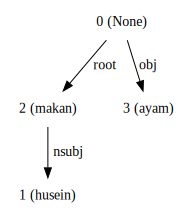

In [22]:
string = 'husein makan ayam'
sequence = transformer_textcleaning(string)[1]
parsed_sequence, segment_sequence, mask_sequence, xlnet_sequence = parse_X(sequence)
h, t = sess.run([model.heads_seq, model.tags_seq],
        feed_dict = {
            model.words: [parsed_sequence],
            model.segment_ids: [segment_sequence],
            model.input_masks: [mask_sequence],
        },
)
h = h[0] - 2
t = [idx2tag[d] for d in t[0]]
merged_h = merge_sentencepiece_tokens_tagging(xlnet_sequence, h)
merged_t = merge_sentencepiece_tokens_tagging(xlnet_sequence, t)
tagging = list(zip(merged_t[0], merged_t[1]))
indexing = list(zip(merged_h[0], merged_h[1]))
dep = dependency_graph(tagging, indexing)
dep.to_graphvis()

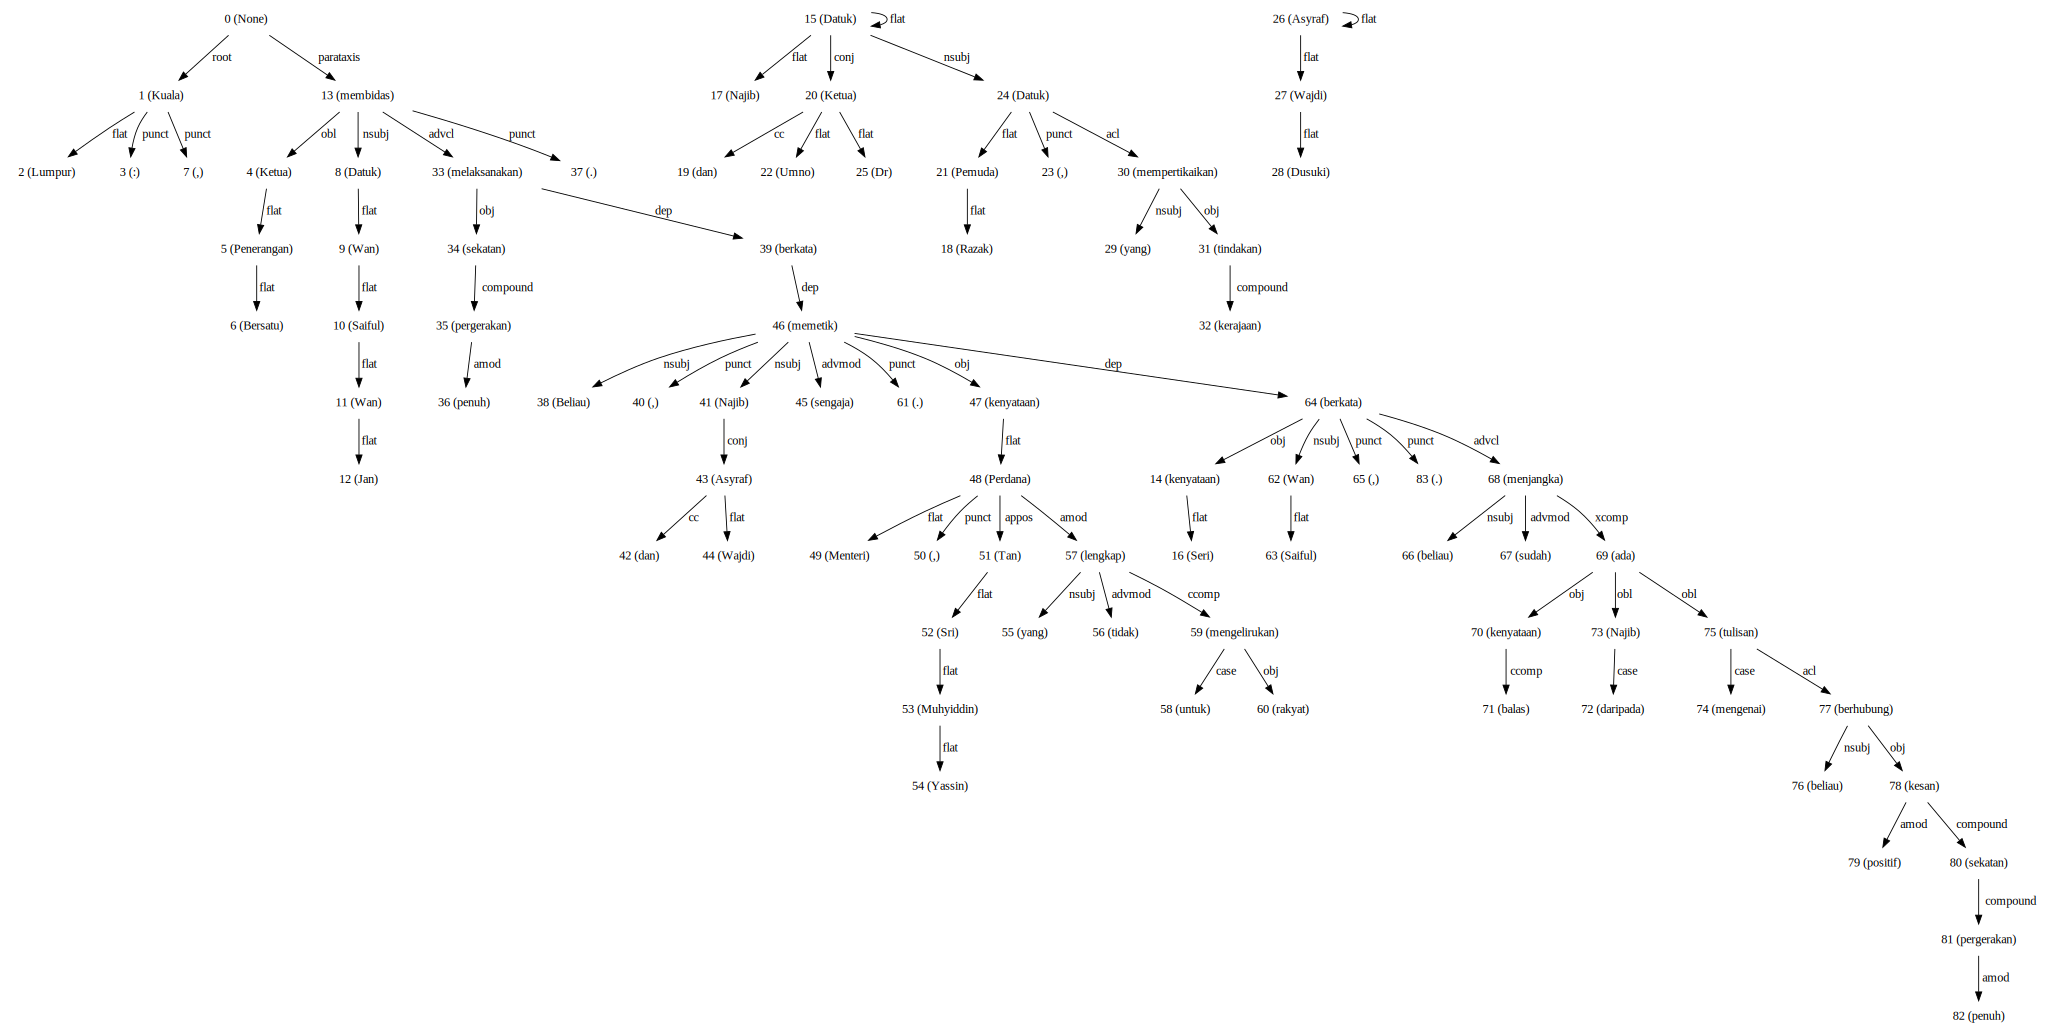

In [23]:
string = 'KUALA LUMPUR: Ketua Penerangan BERSATU, Datuk Wan Saiful Wan Jan membidas kenyataan Datuk Seri Najib Razak dan Ketua Pemuda UMNO, Datuk Dr Asyraf Wajdi Dusuki yang mempertikaikan tindakan kerajaan melaksanakan sekatan pergerakan penuh. Beliau berkata, Najib dan Asyraf Wajdi sengaja memetik kenyataan Perdana Menteri, Tan Sri Muhyiddin Yassin yang tidak lengkap untuk mengelirukan rakyat. Wan Saiful berkata, beliau sudah menjangka ada kenyataan balas daripada Najib mengenai tulisan beliau berhubung kesan positif sekatan pergerakan penuh.'
sequence = transformer_textcleaning(string)[1]
parsed_sequence, segment_sequence, mask_sequence, xlnet_sequence = parse_X(sequence)
h, t = sess.run([model.heads_seq, model.tags_seq],
        feed_dict = {
            model.words: [parsed_sequence],
            model.segment_ids: [segment_sequence],
            model.input_masks: [mask_sequence],
        },
)
h = h[0] - 2
t = [idx2tag[d] for d in t[0]]
merged_h = merge_sentencepiece_tokens_tagging(xlnet_sequence, h)
merged_t = merge_sentencepiece_tokens_tagging(xlnet_sequence, t)
tagging = list(zip(merged_t[0], merged_t[1]))
indexing = list(zip(merged_h[0], merged_h[1]))
dep = dependency_graph(tagging, indexing)
dep.to_graphvis()

In [24]:
saver = tf.train.Saver(tf.trainable_variables())
saver.save(sess, 'alxlnet-base-dependency/model.ckpt')

'alxlnet-base-dependency/model.ckpt'

In [25]:
kwargs = dict(
      is_training=False,
      use_tpu=False,
      use_bfloat16=False,
      dropout=0.0,
      dropatt=0.0,
      init='normal',
      init_range=0.1,
      init_std=0.05,
      clamp_len=-1)

xlnet_parameters = xlnet.RunConfig(**kwargs)
xlnet_config = xlnet.XLNetConfig(
    json_path = 'alxlnet-base-2020-04-10/config.json'
)

In [26]:
learning_rate = 2e-5
hidden_size_word = 256

tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model(learning_rate, hidden_size_word)
sess.run(tf.global_variables_initializer())

INFO:tensorflow:memory input None
INFO:tensorflow:Use float type <dtype: 'float32'>


In [27]:
saver = tf.train.Saver(tf.trainable_variables())
saver.restore(sess, 'alxlnet-base-dependency/model.ckpt')

INFO:tensorflow:Restoring parameters from alxlnet-base-dependency/model.ckpt


In [28]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p])
        out.append(out_i)
    return out

In [29]:
def evaluate(heads_pred, types_pred, heads, types, lengths,
             symbolic_root=False, symbolic_end=False):
    batch_size, _ = heads_pred.shape
    ucorr = 0.
    lcorr = 0.
    total = 0.
    ucomplete_match = 0.
    lcomplete_match = 0.

    corr_root = 0.
    total_root = 0.
    start = 1 if symbolic_root else 0
    end = 1 if symbolic_end else 0
    for i in range(batch_size):
        ucm = 1.
        lcm = 1.
        for j in range(start, lengths[i] - end):

            total += 1
            if heads[i, j] == heads_pred[i, j]:
                ucorr += 1
                if types[i, j] == types_pred[i, j]:
                    lcorr += 1
                else:
                    lcm = 0
            else:
                ucm = 0
                lcm = 0

            if heads[i, j] == 0:
                total_root += 1
                corr_root += 1 if heads_pred[i, j] == 0 else 0

        ucomplete_match += ucm
        lcomplete_match += lcm
    
    return ucorr / total, lcorr / total, corr_root / total_root

In [30]:
arcs, types, roots = [], [], []
real_Y, predict_Y = [], []

for i in tqdm(range(0, len(test_X), batch_size)):
    index = min(i + batch_size, len(test_X))
    batch_x = test_X[i: index]
    batch_x = pad_sequences(batch_x,padding='post')
    batch_y = test_Y[i: index]
    batch_y = pad_sequences(batch_y,padding='post')
    batch_depends = test_depends[i: index]
    batch_depends = pad_sequences(batch_depends,padding='post')
    batch_segments = test_segments[i: index]
    batch_segments = pad_sequences(batch_segments, padding='post', value = 4)
    batch_masks = test_masks[i: index]
    batch_masks = pad_sequences(batch_masks, padding='post', value = 1)
    
    tags_seq, heads = sess.run(
        [model.logits, model.heads_seq],
        feed_dict = {
            model.words: batch_x,
            model.segment_ids: batch_segments,
            model.input_masks: batch_masks
        },
    )
    
    arc_accuracy, type_accuracy, root_accuracy = evaluate(heads - 1, tags_seq, batch_depends - 1, batch_y, 
            np.count_nonzero(batch_x, axis = 1))
    arcs.append(arc_accuracy)
    types.append(type_accuracy)
    roots.append(root_accuracy)
    predicted = pred2label(tags_seq)
    real = pred2label(batch_y)
    predict_Y.extend(predicted)
    real_Y.extend(real)

100%|██████████| 1250/1250 [02:00<00:00, 10.39it/s]


In [31]:
temp_real_Y = []
for r in real_Y:
    temp_real_Y.extend(r)
    
temp_predict_Y = []
for r in predict_Y:
    temp_predict_Y.extend(r)


In [32]:
from sklearn.metrics import classification_report
print(classification_report(temp_real_Y, temp_predict_Y, digits = 5))

               precision    recall  f1-score   support

          PAD    0.99976   1.00000   0.99988    339805
            X    1.00000   0.99936   0.99968     62631
          acl    0.83797   0.82854   0.83323      3202
        advcl    0.63223   0.66865   0.64993      1684
       advmod    0.95967   0.93403   0.94668      6700
         amod    0.90195   0.90054   0.90124      4464
        appos    0.85624   0.74838   0.79869      3088
         case    0.98172   0.98093   0.98133     11117
           cc    0.98209   0.97993   0.98101      3637
        ccomp    0.50143   0.49157   0.49645       356
     compound    0.91041   0.92329   0.91681     11381
compound:plur    0.55000   0.66667   0.60274        33
         conj    0.89766   0.88735   0.89248      5140
          cop    0.96975   0.97302   0.97138       593
        csubj    0.25000   0.16667   0.20000         6
   csubj:pass    0.00000   0.00000   0.00000         1
          dep    0.65012   0.72576   0.68586       361
         

In [33]:
print('arc accuracy:', np.mean(arcs))
print('types accuracy:', np.mean(types))
print('root accuracy:', np.mean(roots))

arc accuracy: 0.8492916621693761
types accuracy: 0.8281206797454291
root accuracy: 0.9209962611210157


In [34]:
strings = ','.join(
    [
        n.name
        for n in tf.get_default_graph().as_graph_def().node
        if ('Variable' in n.op
        or 'Placeholder' in n.name
        or '_seq' in n.name
        or 'logits' in n.name
        or 'alphas' in n.name
        or 'self/Softmax' in n.name)
        and 'Adam' not in n.name
        and 'beta' not in n.name
        and 'global_step' not in n.name
        and 'adam' not in n.name
        and 'gradients/bert' not in n.name
    ]
)

In [35]:
def freeze_graph(model_dir, output_node_names):

    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            'directory: %s' % model_dir
        )

    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path

    absolute_model_dir = '/'.join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + '/frozen_model.pb'
    clear_devices = True
    with tf.Session(graph = tf.Graph()) as sess:
        saver = tf.train.import_meta_graph(
            input_checkpoint + '.meta', clear_devices = clear_devices
        )
        saver.restore(sess, input_checkpoint)
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,
            tf.get_default_graph().as_graph_def(),
            output_node_names.split(','),
        )
        with tf.gfile.GFile(output_graph, 'wb') as f:
            f.write(output_graph_def.SerializeToString())
        print('%d ops in the final graph.' % len(output_graph_def.node))

In [36]:
freeze_graph('alxlnet-base-dependency', strings)

INFO:tensorflow:Restoring parameters from alxlnet-base-dependency/model.ckpt
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 34 variables.
INFO:tensorflow:Converted 34 variables to const ops.
7923 ops in the final graph.


In [37]:
transforms = ['add_default_attributes',
             'remove_nodes(op=Identity, op=CheckNumerics, op=Dropout)',
             'fold_batch_norms',
             'fold_old_batch_norms',
             'quantize_weights(fallback_min=-10, fallback_max=10)',
             'strip_unused_nodes',
             'sort_by_execution_order']

In [38]:
from tensorflow.tools.graph_transforms import TransformGraph
tf.set_random_seed(0)

pb = 'alxlnet-base-dependency/frozen_model.pb'
input_graph_def = tf.GraphDef()
with tf.gfile.FastGFile(pb, 'rb') as f:
    input_graph_def.ParseFromString(f.read())

if 'bert' in pb:
    inputs = ['Placeholder']
    a = ['dense/BiasAdd']
if 'xlnet' in pb:
    inputs = ['Placeholder', 'Placeholder_1', 'Placeholder_2']
    a = ['transpose_3']

transformed_graph_def = TransformGraph(input_graph_def, 
                                       inputs,
                                       ['logits', 'heads_seq'] + a, transforms)

with tf.gfile.GFile(f'{pb}.quantized', 'wb') as f:
    f.write(transformed_graph_def.SerializeToString())

Instructions for updating:
Use tf.gfile.GFile.
